# COGS 118A - Final Project

# Insert title here(To Do)

# Names

- Sam Schwartz
- Campbell Moco
- Chris Molina
- Ryan Desmond

# Abstract 
We want to make a model that predict the sentiment of a review based on a drug review. To make this model we are using data from the UCI ML Drug Review dataset which displays thousands of observations of patients’ reviews and ratings of certain drugs along side what condition they took the drug for and how many users found their review useful. To achieve our goal, we will first clean up our data in order to clear out noise, then implement several classification algorithm such as decision trees or K-nearest Neighbors to determine if the review has positive or negative sentiment. Once the algorithms have run, we can use model-selection to determine the most accurate model for our analysis. To test the performance of our model we will split the data into a train and test group and compare the two.


# Background

Prescribing the proper drug to use for any given condition or circumstance is one of the most important aspects of being a physician<a name="rational"></a>[<sup>[1]</sup>](#rationalnote). For any given disease that requires treatment, there may be thousands of drug options and potentially infinite variation in the patients which makes reaching a decision about a prescribed drug and treatment plan a cognitively difficult task. Even then, once a drug is prescribed, it could have negative effects for the patient that could prove just as troublesome as the original problem. Rational prescribing refers to the methodology physicians use when choosing what drug to prescribe (diagnosing, assessing prognosis and patient goals, establishing treatment plan, and monitoring the treatment)<a name="rational"></a>[<sup>[1]</sup>](#rationalnote). Finding a model that would optimize patient care and increase patient satisfaction would be beneficial for not just the patients, but also the physicians who monitor the treatment plan. It could also potentially lead to a standardization of rational prescribing for physicians globally.
   
WHO estimates that more than half of the drugs prescribed, are prescribed inappropriately to the patient meaning that the drug prescribed was not the best possible choice for the patient<a name="who"></a>[<sup>[2]</sup>](#whonote). It is a global issue that has created excessive waste of scarce resources and in some cases has contributed to wide-spread health hazards. An example would be the overuse of injections when oral formulations would be considered more appropriate for the situation<a name="who"></a>[<sup>[2]</sup>](#whonote). Using a model that captures the process of rational prescription could reduce the number of inappropriate prescriptions which could potentially lead to more resources and reduce the likelihood of health hazards.
    
This model could also potentially help physicians who are “pathologically prescribing”. A study that randomly sampled from registered medical practitioners showed that more than 60% of prescription antibiotics were prescribed without enough indication to do so as well as a lesser duration period than would be effective for treatment<a name="irrational"></a>[<sup>[3]</sup>](#irrationalnote). As humans, we eventually become desensitized and habituated to our environments after prolonged exposure. What this means for physicians or registered medical practitioners is that eventually one might see symptoms that are common with certain diseases and think that the common prescription for that disease may be substantial. However, each patient is different and there could perhaps be slight differences that physicians miss. A model that could distinguish between those differences and help physicians make more appropriate choices for the specific patient rather than the general circumstances usually associated with the problem could be beneficial for both patient and physician.

# Problem Statement

Machine learning is a very powerful tool that can be used in natural language processing. This tool can help aid both individuals and other machines when trying to determine the sentiment of a drug review.


# Data

Link to the dataset: https://www.kaggle.com/datasets/jessicali9530/kuc-hackathon-winter-2018?select=drugsComTest_raw.csv

The dataset we looked at is the UCI Machine Learning Repository Drug Review Dataset. It has 48,000 observation and 7 variables. A single observation includes a unique id of the patient, name of the drug they were using, what condition they used it for, a written out review of the drug, a rating out of 10, date of the review, and number of users who found the review helpful. In order to properly use the dataset, we will have to clean the date into a usable format, as well as clean up the reviews since a lot of them aren't in formal language.

# Data Preprocessing

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import string
import html
import sys

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, f1_score, mean_squared_error
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import zero_one_loss, accuracy_score, roc_auc_score, f1_score
from sklearn.metrics import plot_roc_curve, plot_precision_recall_curve
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

from collections import Counter
from wordcloud import WordCloud, STOPWORDS

In [3]:
train_str = 'drugsComTrain_raw.tsv'
test_str = 'drugsComTest_raw.tsv'
train_df = pd.read_csv(train_str, sep='\t')
test_df = pd.read_csv(test_str, sep='\t')

In [6]:
# Merging both train and test sets, we will be using sklearn's split
full_df = pd.concat([train_df, test_df], ignore_index=True)

In [8]:
# Look at the whole dataset
full_df.head()

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,"May 20, 2012",27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,"April 27, 2010",192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,"December 14, 2009",17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0,"November 3, 2015",10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0,"November 27, 2016",37


In [9]:
# Rename "Unnamed: 0"
full_df.rename(columns={'Unnamed: 0': 'uniqueID'}, inplace=True)

In [10]:
# Make sure changes were implemented
full_df.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,"May 20, 2012",27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,"April 27, 2010",192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,"December 14, 2009",17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0,"November 3, 2015",10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0,"November 27, 2016",37


In [11]:
# Find where NaN values are (if any)
print(full_df.isnull().sum())

uniqueID          0
drugName          0
condition      1194
review            0
rating            0
date              0
usefulCount       0
dtype: int64


In [12]:
# Removing null values
full_df.dropna(inplace=True)

# Make sure the removal worked
print(full_df.isnull().sum())

uniqueID       0
drugName       0
condition      0
review         0
rating         0
date           0
usefulCount    0
dtype: int64


In [13]:
# Looking at all the unique values of our training set to see if there are any problematic values
full_df.condition.unique()

array(['Left Ventricular Dysfunction', 'ADHD', 'Birth Control',
       'Opiate Dependence', 'Benign Prostatic Hyperplasia',
       'Emergency Contraception', 'Bipolar Disorde', 'Epilepsy',
       'Migraine Prevention', 'Depression', "Crohn's Disease", 'Cough',
       'Obesity', 'Urinary Tract Infection', 'ibromyalgia',
       'Chronic Myelogenous Leukemia', 'HIV Infection', 'Insomnia',
       'Rheumatoid Arthritis', 'Vaginal Yeast Infection',
       'Chlamydia Infection', 'Hirsutism', 'Panic Disorde', 'Migraine',
       'Pain', 'Irritable Bowel Syndrome', 'Osteoarthritis',
       'Constipation', 'Bowel Preparation', 'Psychosis', 'Muscle Spasm',
       'Hepatitis C', 'Overactive Bladde', 'Diabetes, Type 2',
       'Asthma, Maintenance', 'Non-Small Cell Lung Cance',
       'Schizophrenia', 'Dysuria', 'Smoking Cessation', 'Anxiety', 'Acne',
       'emale Infertility', 'Constipation, Acute',
       'Constipation, Drug Induced', 'Erectile Dysfunction',
       'Trigeminal Neuralgia', 'Undera

In [14]:
# Remove all data with HTML values in condition
full_df = full_df[full_df['condition'].str.contains("</span>") == False]
full_df.condition.unique()

array(['Left Ventricular Dysfunction', 'ADHD', 'Birth Control',
       'Opiate Dependence', 'Benign Prostatic Hyperplasia',
       'Emergency Contraception', 'Bipolar Disorde', 'Epilepsy',
       'Migraine Prevention', 'Depression', "Crohn's Disease", 'Cough',
       'Obesity', 'Urinary Tract Infection', 'ibromyalgia',
       'Chronic Myelogenous Leukemia', 'HIV Infection', 'Insomnia',
       'Rheumatoid Arthritis', 'Vaginal Yeast Infection',
       'Chlamydia Infection', 'Hirsutism', 'Panic Disorde', 'Migraine',
       'Pain', 'Irritable Bowel Syndrome', 'Osteoarthritis',
       'Constipation', 'Bowel Preparation', 'Psychosis', 'Muscle Spasm',
       'Hepatitis C', 'Overactive Bladde', 'Diabetes, Type 2',
       'Asthma, Maintenance', 'Non-Small Cell Lung Cance',
       'Schizophrenia', 'Dysuria', 'Smoking Cessation', 'Anxiety', 'Acne',
       'emale Infertility', 'Constipation, Acute',
       'Constipation, Drug Induced', 'Erectile Dysfunction',
       'Trigeminal Neuralgia', 'Undera

In [15]:
# Looking at the review column
full_df['review']

0         "It has no side effect, I take it in combinati...
1         "My son is halfway through his fourth week of ...
2         "I used to take another oral contraceptive, wh...
3         "This is my first time using any form of birth...
4         "Suboxone has completely turned my life around...
                                ...                        
215058    "I have taken Tamoxifen for 5 years. Side effe...
215059    "I&#039;ve been taking Lexapro (escitaploprgra...
215060    "I&#039;m married, 34 years old and I have no ...
215061    "I was prescribed Nucynta for severe neck/shou...
215062                                        "It works!!!"
Name: review, Length: 212698, dtype: object

In [16]:
# Convert all HTML characters to strings
full_df['review'] = full_df['review'].apply(lambda val: html.unescape(val))

In [17]:
# We need to clean this data up a bit by removing contractions,
# lowercasing the review, removing numbers, and punctuation

# https://www.analyticsvidhya.com/blog/2020/04/beginners-guide-exploratory-data-analysis-text-data/

# Dictionary of English Contractions, 
contractions_dict = { "ain't": "are not","'s":" is","aren't": "are not",
                     "can't": "cannot","can't've": "cannot have",
                     "'cause": "because","could've": "could have","couldn't": "could not",
                     "couldn't've": "could not have", "didn't": "did not","doesn't": "does not",
                     "don't": "do not","hadn't": "had not","hadn't've": "had not have",
                     "hasn't": "has not","haven't": "have not","he'd": "he would",
                     "he'd've": "he would have","he'll": "he will", "he'll've": "he will have",
                     "how'd": "how did","how'd'y": "how do you","how'll": "how will",
                     "I'd": "I would", "I'd've": "I would have","I'll": "I will",
                     "I'll've": "I will have","I'm": "I am","I've": "I have", "isn't": "is not",
                     "it'd": "it would","it'd've": "it would have","it'll": "it will",
                     "it'll've": "it will have", "let's": "let us","ma'am": "madam",
                     "mayn't": "may not","might've": "might have","mightn't": "might not", 
                     "mightn't've": "might not have","must've": "must have","mustn't": "must not",
                     "mustn't've": "must not have", "needn't": "need not",
                     "needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not",
                     "oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not",
                     "shan't've": "shall not have","she'd": "she would","she'd've": "she would have",
                     "she'll": "she will", "she'll've": "she will have","should've": "should have",
                     "shouldn't": "should not", "shouldn't've": "should not have","so've": "so have",
                     "that'd": "that would","that'd've": "that would have", "there'd": "there would",
                     "there'd've": "there would have", "they'd": "they would",
                     "they'd've": "they would have","they'll": "they will",
                     "they'll've": "they will have", "they're": "they are","they've": "they have",
                     "to've": "to have","wasn't": "was not","we'd": "we would",
                     "we'd've": "we would have","we'll": "we will","we'll've": "we will have",
                     "we're": "we are","we've": "we have", "weren't": "were not","what'll": "what will",
                     "what'll've": "what will have","what're": "what are", "what've": "what have",
                     "when've": "when have","where'd": "where did", "where've": "where have",
                     "who'll": "who will","who'll've": "who will have","who've": "who have",
                     "why've": "why have","will've": "will have","won't": "will not",
                     "won't've": "will not have", "would've": "would have","wouldn't": "would not",
                     "wouldn't've": "would not have","y'all": "you all", "y'all'd": "you all would",
                     "y'all'd've": "you all would have","y'all're": "you all are",
                     "y'all've": "you all have", "you'd": "you would","you'd've": "you would have",
                     "you'll": "you will","you'll've": "you will have", "you're": "you are",
                     "you've": "you have"}

# Regular expression for finding contractions
contractions_re=re.compile('(%s)' % '|'.join(contractions_dict.keys()))

# Function for expanding contractions
def expand_contractions(text,contractions_dict=contractions_dict):
  def replace(match):
    return contractions_dict[match.group(0)]
  return contractions_re.sub(replace, text)

# Expanding Contractions in the reviews
full_df['review'] = full_df['review'].apply(lambda x:expand_contractions(x))

In [18]:
# Remove all digits and punctuation
def remove_digits(text):
    for digit in string.digits:
        text = text.replace(digit, '')
    return text

def remove_punctuations(text):
    for punc in string.punctuation:
        text = text.replace(punc, '')
    return text

full_df['review'] = full_df['review'].apply(remove_digits)
full_df['review'] = full_df['review'].apply(remove_punctuations)

In [19]:
# Set all reviews to lowercase
full_df['review'] = full_df['review'].str.lower()

In [20]:
# Remove newlines and tabs
# https://stackoverflow.com/questions/44227748/removing-newlines-from-messy-strings-in-pandas-dataframe-cells
full_df['review'] = full_df['review'].replace(r'\r+|\n+|\t+', '', regex=True)

In [21]:
# Make sure changes went through
full_df['review'][1]

'my son is halfway through his fourth week of intuniv we became concerned when he began this last week when he started taking the highest dose he will be on for two days he could hardly get out of bed was very cranky and slept for nearly  hours on a drive home from school vacation very unusual for him i called his doctor on monday morning and she said to stick it out a few days see how he did at school and with getting up in the morning the last two days have been problem free he is much more agreeable than ever he is less emotional a good thing less cranky he is remembering all the things he should overall his behavior is better we have tried many different medications and so far this is the most effective'

In [22]:
# We are almost ready to perform EDA, but we need to remove our stopwords.
# https://stackoverflow.com/questions/25346058/removing-list-of-words-from-a-string

stopwords = list(STOPWORDS)
def remove_stopwords(text):
    arr = text.split()
    res = [word for word in arr if word not in stopwords]
    text = ' '.join(res)
    return text

full_df['review'] = full_df['review'].apply(remove_stopwords)

In [23]:
full_df['review'][1]

'son halfway fourth week intuniv became concerned began last week started taking highest dose will two days hardly bed cranky slept nearly hours drive home school vacation unusual called doctor monday morning said stick days see school getting morning last two days problem free much agreeable less emotional good thing less cranky remembering things overall behavior better tried many different medications far effective'

# EDA

In [24]:
print("Data shape", full_df.shape)

Data shape (212698, 7)


In [25]:
full_df.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,side effect take combination bystolic mg fish oil,9.0,"May 20, 2012",27
1,95260,Guanfacine,ADHD,son halfway fourth week intuniv became concern...,8.0,"April 27, 2010",192
2,92703,Lybrel,Birth Control,used take another oral contraceptive pill cycl...,5.0,"December 14, 2009",17
3,138000,Ortho Evra,Birth Control,first time using form birth control glad went ...,8.0,"November 3, 2015",10
4,35696,Buprenorphine / naloxone,Opiate Dependence,suboxone completely turned life around feel he...,9.0,"November 27, 2016",37


In [26]:
# We can see the number of unique values in the table
full_df.nunique()

uniqueID       212698
drugName         3654
condition         836
review         126870
rating             10
date             3579
usefulCount       397
dtype: int64

Top 10 positive words [('day', 53187), ('now', 53148), ('side', 51922), ('years', 49848), ('taking', 46466), ('mg', 45917), ('take', 44161), ('effects', 43453), ('first', 42658), ('pain', 41288)]


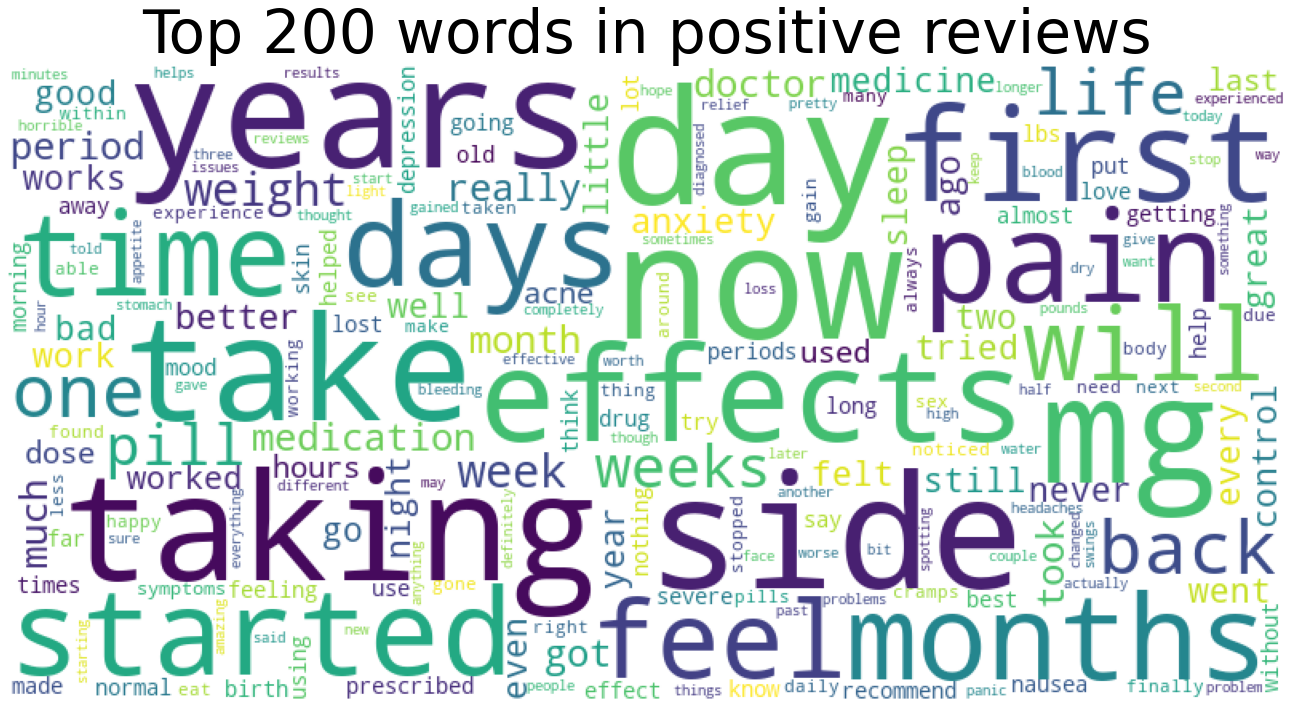

In [27]:
# Lets make wordclouds of the top 200 words in the positive and negative classes, 
# where 1-5 ratings are positive and 6-10 ratings are negative

pos_df = full_df[full_df['rating'] > 5]

pos_words = Counter(" ".join(pos_df['review']).split()).most_common(200)

d = {}

for pair in pos_words:
    d[pair[0]] = pair[1]

wordcloud = WordCloud(background_color='white',
                    stopwords = set(STOPWORDS),
                    max_words = 200,
                    max_font_size = 100, 
                    random_state = 42,
                    width=800, 
                    height=400)

wordcloud.generate_from_frequencies(d)
plt.figure(figsize=(20.0,10.0))
plt.imshow(wordcloud)
plt.title("Top 200 words in positive reviews", fontdict={'size': 60})
plt.axis('off')
plt.tight_layout()
print("Top 10 positive words", pos_words[:10])

Top 10 negative words [('taking', 20875), ('day', 20736), ('months', 19101), ('now', 18990), ('pain', 17729), ('started', 17598), ('side', 17239), ('days', 16685), ('first', 16300), ('time', 15092)]


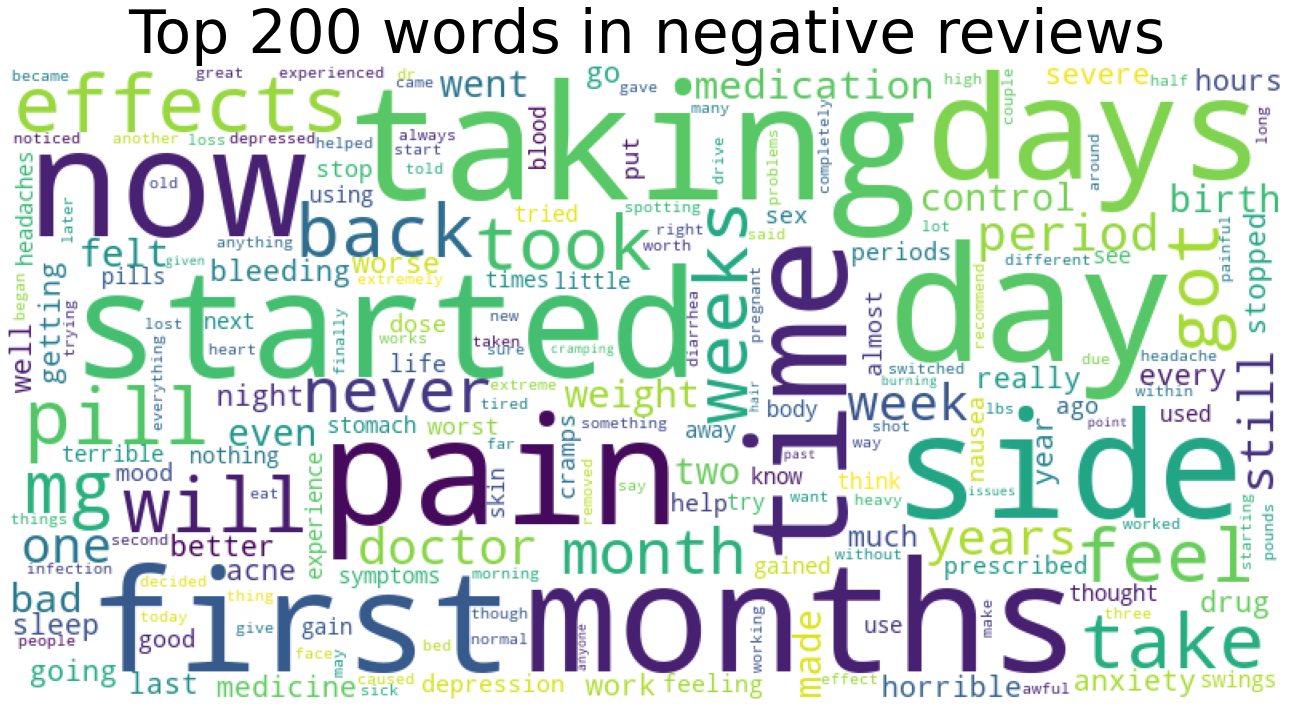

In [28]:
# We can visualize the negative reviews too
neg_df = full_df[full_df['rating'] < 6]

neg_words = Counter(" ".join(neg_df['review']).split()).most_common(200)

d = {}

for pair in neg_words:
    d[pair[0]] = pair[1]

wordcloud = WordCloud(background_color='white',
                    stopwords = set(STOPWORDS),
                    max_words = 200,
                    max_font_size = 100, 
                    random_state = 42,
                    width=800, 
                    height=400)

wordcloud.generate_from_frequencies(d)
plt.figure(figsize=(20.0,10.0))
plt.imshow(wordcloud)
plt.title("Top 200 words in negative reviews", fontdict={'size': 60})
plt.axis('off')
plt.tight_layout()
print("Top 10 negative words", neg_words[:10])

Top 10 positive words [('mg', 14383), ('years', 12911), ('day', 11876), ('side', 11857), ('now', 11766), ('taking', 11276), ('pain', 10536), ('effects', 10358), ('take', 10352), ('life', 10246)]


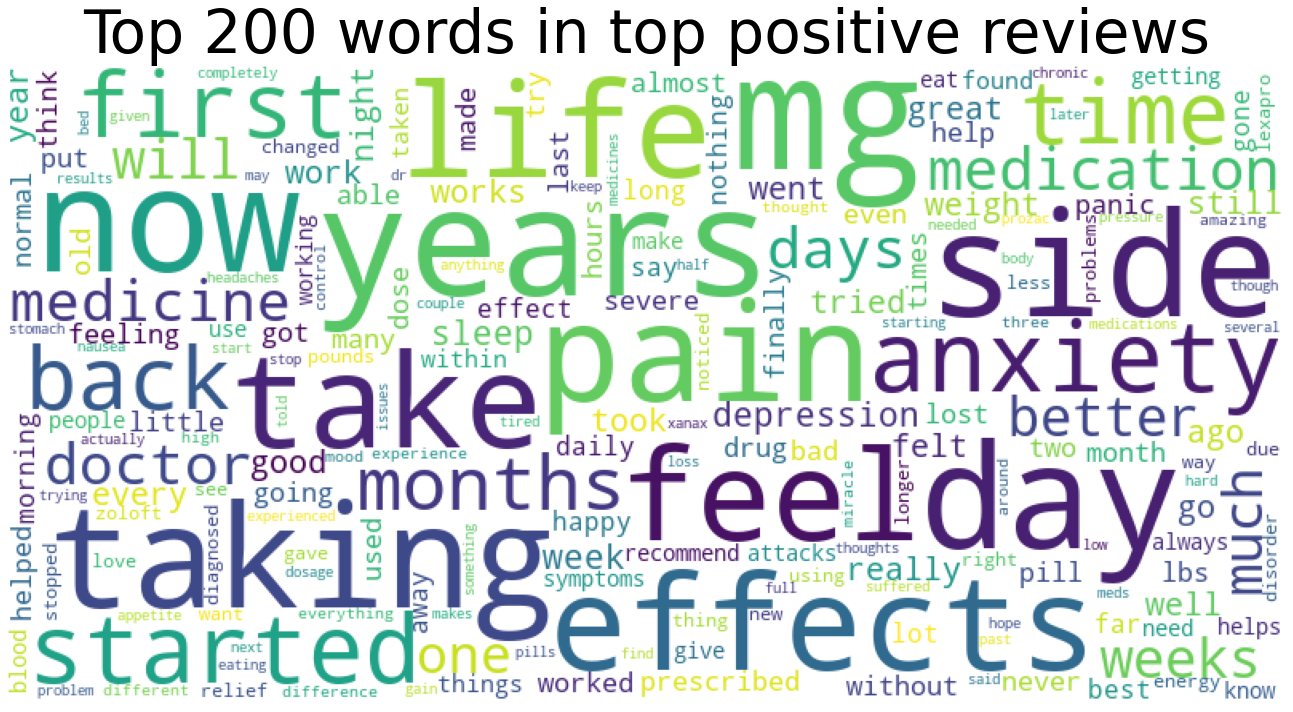

In [29]:
# We can also visualize the top 200 words of the highest-rated positive reviews
use_p_df = full_df[(full_df['usefulCount'] > 50) & (full_df['rating'] > 5)]

use_p_words = Counter(" ".join(use_p_df['review']).split()).most_common(200)

d = {}

for pair in use_p_words:
    d[pair[0]] = pair[1]

wordcloud = WordCloud(background_color='white',
                    stopwords = set(STOPWORDS),
                    max_words = 200,
                    max_font_size = 100, 
                    random_state = 42,
                    width=800, 
                    height=400)

wordcloud.generate_from_frequencies(d)
plt.figure(figsize=(20.0,10.0))
plt.imshow(wordcloud)
plt.title("Top 200 words in top positive reviews", fontdict={'size': 60})
plt.axis('off')
plt.tight_layout()
print("Top 10 positive words", use_p_words[:10])

Top 10 negative words [('pain', 1564), ('taking', 1533), ('side', 1479), ('effects', 1242), ('mg', 1128), ('day', 1039), ('started', 932), ('now', 911), ('medication', 899), ('doctor', 844)]


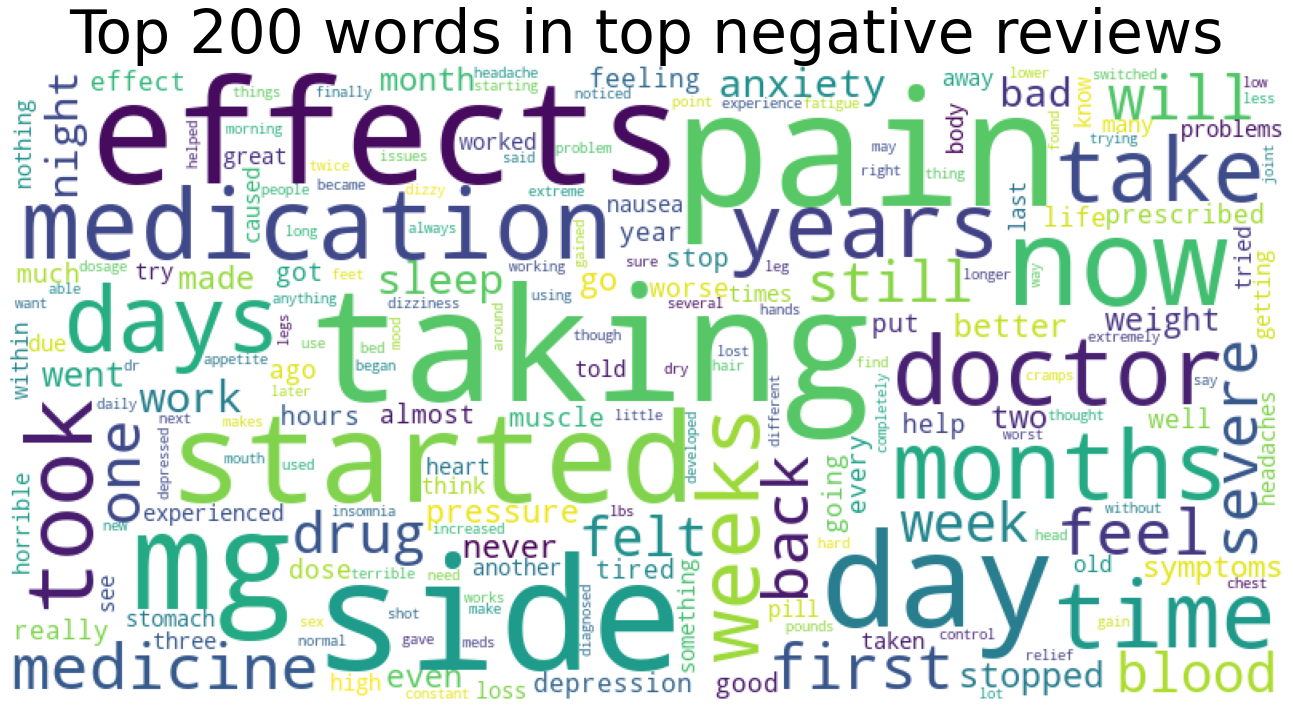

In [30]:
# We can also visualize the top 200 words of the highest-rated negative reviews
use_n_df = full_df[(full_df['usefulCount'] > 50) & (full_df['rating'] < 6)]

use_n_words = Counter(" ".join(use_n_df['review']).split()).most_common(200)

d = {}

for pair in use_n_words:
    d[pair[0]] = pair[1]

wordcloud = WordCloud(background_color='white',
                    stopwords = set(STOPWORDS),
                    max_words = 200,
                    max_font_size = 100, 
                    random_state = 42,
                    width=800, 
                    height=400)

wordcloud.generate_from_frequencies(d)
plt.figure(figsize=(20.0,10.0))
plt.imshow(wordcloud)
plt.title("Top 200 words in top negative reviews", fontdict={'size': 60})
plt.axis('off')
plt.tight_layout()
print("Top 10 negative words", use_n_words[:10])

# Proposed Solution

We will use the cleaned data and perform a sentiment analysis on each review separating different reviews into positive or negative based on their language and rating. We will then perform model selection to determine the highest-accuracy model for our binary classification.

# Evaluation Metrics

We are going to use accuracy, precision, and recall as evaluation metrics. We chose to use these 3 because we thought they were all important for our model. We plan on using a confusion matrix as well.

# Results

## Sentiment Analysis
Since we are using reviews and ratings for our project we will use sentiment analysis by creating a new column "sentiment" which states whether the rating was positive if it was a score of 5 or higher or negative if the score was less than 5. We will then develop models that predicts what drug should be perscribed based on the condition of the patient. The two models that we will be working with are Logistic Regression and Gridsearch Cross Validation. We will then compare these two models and determine which one is better.

In [31]:
full_df

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,side effect take combination bystolic mg fish oil,9.0,"May 20, 2012",27
1,95260,Guanfacine,ADHD,son halfway fourth week intuniv became concern...,8.0,"April 27, 2010",192
2,92703,Lybrel,Birth Control,used take another oral contraceptive pill cycl...,5.0,"December 14, 2009",17
3,138000,Ortho Evra,Birth Control,first time using form birth control glad went ...,8.0,"November 3, 2015",10
4,35696,Buprenorphine / naloxone,Opiate Dependence,suboxone completely turned life around feel he...,9.0,"November 27, 2016",37
...,...,...,...,...,...,...,...
215058,159999,Tamoxifen,"Breast Cancer, Prevention",taken tamoxifen years side effects severe swea...,10.0,"September 13, 2014",43
215059,140714,Escitalopram,Anxiety,taking lexapro escitaploprgram february first ...,9.0,"October 8, 2016",11
215060,130945,Levonorgestrel,Birth Control,married years old kids taking pill hassle deci...,8.0,"November 15, 2010",7
215061,47656,Tapentadol,Pain,prescribed nucynta severe neckshoulder pain ta...,1.0,"November 28, 2011",20


In [32]:
clean_df = full_df.drop(['drugName', 'condition', 'uniqueID', 'date', 'usefulCount'], axis=1)

In [33]:
# We'll add the sentiment (postive/negative) by 1 - 5 being negative, 6-10 being positive

def rating(num):
    if(num <= 5):
        return 'negative'
    else:
        return 'positive'

clean_df['sentiment'] = clean_df.rating.apply(rating)

In [34]:
clean_df

,review,rating,sentiment
0,side effect take combination bystolic mg fish oil,9.0,positive
1,son halfway fourth week intuniv became concern...,8.0,positive
2,used take another oral contraceptive pill cycl...,5.0,negative
3,first time using form birth control glad went ...,8.0,positive
4,suboxone completely turned life around feel he...,9.0,positive
...,...,...,...
215058,taken tamoxifen years side effects severe swea...,10.0,positive
215059,taking lexapro escitaploprgram february first ...,9.0,positive
215060,married years old kids taking pill hassle deci...,8.0,positive
215061,prescribed nucynta severe neckshoulder pain ta...,1.0,negative


In [35]:
clean_df['sentiment'].value_counts()

positive    149176
negative     63522
Name: sentiment, dtype: int64

In [36]:
clean_df = clean_df.drop(['rating'], axis=1)

In [37]:
X = clean_df.review
y = clean_df.sentiment

# One-hot encode 'positive' -> 1, 'negative' -> 0
y = np.unique(y, return_inverse=True)[1]
y

array([1, 1, 0, ..., 1, 0, 1], dtype=int64)

In [38]:
X.shape

(212698,)

## Logistic Regression
We chose to use Logistic regression as our base model using a pipeline that utilizes a count vectorizer to create our train test split. The model ended up with an accuracy score of .856 which although isn't the best is still high enough to be used as a reliable model.

In [39]:
cv = CountVectorizer()
pipe = Pipeline([('vect', cv)])

X_features = pipe.fit_transform(X)

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X_features, y, test_size=0.2, random_state=42)

In [41]:
# Baseline model
model = LogisticRegression(solver='saga', random_state=0, 
                           max_iter=4000, verbose=3)

model.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 2243 epochs took 317 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  5.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  5.3min finished


LogisticRegression(max_iter=4000, random_state=0, solver='saga', verbose=3)

In [42]:
y_pred = model.predict(X_test)

In [43]:
accuracy_score(y_test, y_pred)

0.8569346497414199

## Gridsearch Cross Validation
Continuing to use Logistic Regression as our base model, we conducted a Gridsearch Cross Validation(GSCV) that has 5 folds, using 6 different values of C starting from 0.0001 and multiplies by 10 until C is 1 and 2 different solvers, "sag" and "saga" having a total of 12 candidates. The model with the highest score was very similar to the base models being at, .85, with C = 1 and solver = "sag".

In [44]:
# Gridserch CV for best hyperparams:

gs_model = LogisticRegression(random_state=0, max_iter=4000)
gscv = GridSearchCV(gs_model, param_grid={'C': [0.0001, 0.001, 0.01, 0.01, 0.1, 1], 'solver': ['sag', 'saga']}, verbose=3)
gscv.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END ...........................C=0.0001, solver=sag; total time=   4.3s
[CV 2/5] END ...........................C=0.0001, solver=sag; total time=   4.4s
[CV 3/5] END ...........................C=0.0001, solver=sag; total time=   4.2s
[CV 4/5] END ...........................C=0.0001, solver=sag; total time=   2.7s
[CV 5/5] END ...........................C=0.0001, solver=sag; total time=   4.3s
[CV 1/5] END ..........................C=0.0001, solver=saga; total time=  17.1s
[CV 2/5] END ..........................C=0.0001, solver=saga; total time=  17.6s
[CV 3/5] END ..........................C=0.0001, solver=saga; total time=  17.1s
[CV 4/5] END ..........................C=0.0001, solver=saga; total time=  10.8s
[CV 5/5] END ..........................C=0.0001, solver=saga; total time=  16.7s
[CV 1/5] END ............................C=0.001, solver=sag; total time=   5.5s
[CV 2/5] END ............................C=0.001

GridSearchCV(estimator=LogisticRegression(max_iter=4000, random_state=0),
             param_grid={'C': [0.0001, 0.001, 0.01, 0.01, 0.1, 1],
                         'solver': ['sag', 'saga']},
             verbose=3)

In [45]:
gscv.cv_results_['mean_test_score']

array([0.71173262, 0.71192656, 0.78728594, 0.78879042, 0.82310558,
       0.82436323, 0.82310558, 0.82436323, 0.83790361, 0.83785072,
       0.85049779, 0.84996887])

## ROC Curve 
We then found the True Positive Rate(TPR) and the False Positive Rate(FPR) and created a Receiver Operator Characteristic(ROC) Curve. The ROC Curve helps prove our model to be accurate as it has has a high Area Under the Curve(AOC) at 0.91 and approaches TPR = 1 very quickly.

In [46]:
# C=1, solver='sag' is the best in terms of avg. acc %

predictions = gscv.predict_proba(X_test)[:,1]

roc_auc = roc_auc_score(y_test, predictions)
fpr, tpr, _ = roc_curve(y_test, predictions)

Area under the Receiver Operating Characteristic curve: 0.9105622567675073


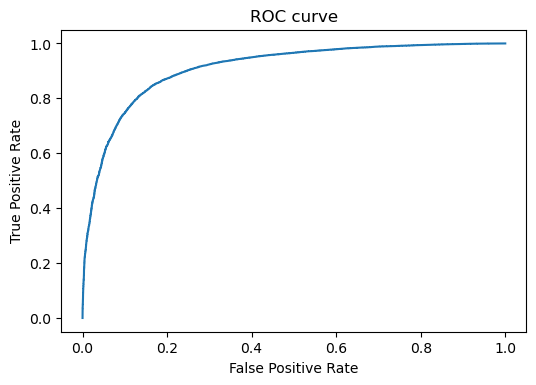

In [47]:
plt.figure(dpi=100)
plt.plot(fpr, tpr)
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

print('Area under the Receiver Operating Characteristic curve:', 
      roc_auc)

# Confusion Matrix
We made a Confusion Matrix that displays the number of true and false predictions of our model which is used to find the recall and percision. This matrix also helps prove the quality of the model as it produces high recall and percision values at 0.95 and 0.91

In [ ]:
y_pred_train = gscv.predict(X_train)
y_pred_test = gscv.predict(X_test)
confusion_matrix(y_test, y_pred_test)

array([[ 8822,  3748],
       [ 2309, 27661]], dtype=int64)

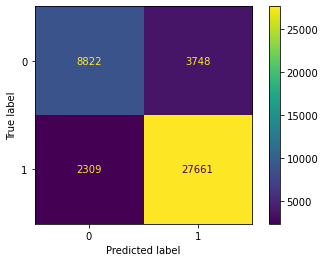

In [65]:
plot_confusion_matrix(gscv, X_test, y_test)
confusion_matrix(y_test, y_pred_test)

In [49]:
gscv_pred = gscv.predict(X_test)
f1_score(y_test, gscv_pred)

0.9013180403721143

In [77]:
true_negatives, false_positives, false_negatives, true_positives = confusion_matrix(y_train, y_pred_train).ravel()
recall = true_positives / (true_positives + false_negatives)
percision = true_positives / (true_positives + false_positives)
print('Recall:', recall)
print('Percision:', percision)

Recall: 0.9513950640068453
Percision: 0.911620728737129


# Discussion

### Interpreting the result 

After analyzing our results we have concluded that our model found through GSCV to be very effective. Although the accuracy (0.85) is a little low and almost exactly the same as the Logistic Regression model used without GSCV, the ROC curve and the recall and percision prove that our model can be reliable. The ROC curve produced by our model is almost perfect having a smooth exponential rise towards TPR = 1 creating an AOC of 0.91 displaying there is a high measure of seperability between our classes. The high recall and percision values at 0.95 and 0.91 show how rare it is for the model to predict false positives and false negatives.

### Limitations (To Do)

Are there any problems with the work?  For instance would more data change the nature of the problem? Would it be good to explore more hyperparams than you had time for?   

### Ethics & Privacy

Some ethics and privacy issues of this project can include potential bias in the data collection and informed consent since neither we nor UCSD does not have access to the publication on how the data was collected. There might not be enough honest representation of the populations that take these different drugs or have these conditions in the data, and there is a potential that the sentiment classification could be used for a patient to switch to a different type of drug for their condition, leading to potentially bad consequences as a result. A possible way to mitigate this problem would be to have clear end-user license agreement stating that this project was meant for educational purposes only.

### Conclusion (To Do)

Reiterate your main point and in just a few sentences tell us how your results support it. Mention how this work would fit in the background/context of other work in this field if you can. Suggest directions for future work if you want to.

# Footnotes
<a name="rationalnote"></a>1.[^](#rational): Maxwell, S. R. (2016, October). Rational prescribing: The principles of drug selection. Clinical medicine (London, England). Retrieved April 24, 2022, from https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6297291/

<a name="whonote"></a>2.[^](#who): World Health Organization. (n.d.). Promoting rational use of medicines. World Health Organization. Retrieved April 24, 2022, from https://www.who.int/activities/promoting-rational-use-of-medicines

<a name="irrationalnote"></a>3.[^](#irrational): Garg, M., Vishwakarma, P., Sharma, M., Nehra, R., &amp; Saxena, K. K. (2014, October). The impact of irrational practices: A wake up call. Journal of pharmacology &amp; pharmacotherapeutics. Retrieved April 24, 2022, from https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4231553/ 
